In [154]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

In [155]:
# read csv files
ratings = pd.read_csv('BX-Ratings.csv')
books = pd.read_csv('BX-Books.csv')
users = pd.read_csv('BX-Users.csv')

In [156]:
# check the data type of books before processing
users.head()
print(users.dtypes)

User-ID          int64
User-City       object
User-State      object
User-Country    object
User-Age        object
dtype: object


In [157]:
# check missing data
missing_users = users.isna().sum()
print(missing_users)
print(" ")


User-ID             0
User-City          61
User-State          0
User-Country      669
User-Age        18952
dtype: int64
 


In [158]:
# normalisation in users city, state, country
# convert letters into lower case
# reolacing missing data with NA
users["User-Country"] = users["User-Country"].str.replace('"', ' ').str.lower().str.strip().replace('', pd.NA)
users["User-City"] = users["User-City"].str.replace('"', ' ').str.lower().str.strip().replace('', pd.NA)
users["User-State"] = users["User-State"].str.replace('"', ' ').str.lower().str.strip().replace('', pd.NA)
users["User-Age"] = users["User-Age"].str.replace('"', ' ').replace('NaN', pd.NA).astype(float).astype('Int64')

print(users)

       User-ID    User-City  User-State User-Country  User-Age
0            8      timmins     ontario       canada      <NA>
1            9   germantown   tennessee          usa      <NA>
2           16  albuquerque  new mexico          usa      <NA>
3           17   chesapeake    virginia          usa      <NA>
4           19       weston        <NA>          NaN        14
...        ...          ...         ...          ...       ...
48294   278846      toronto     ontario       canada        23
48295   278849   georgetown     ontario       canada        23
48296   278851       dallas       texas          usa        33
48297   278852     brisbane  queensland    australia        32
48298   278854     portland      oregon          usa      <NA>

[48299 rows x 5 columns]


In [159]:
# check missing values
missing_users = users.isna().sum()
print(missing_users)

User-ID             0
User-City          61
User-State        666
User-Country      669
User-Age        18952
dtype: int64


In [160]:
# base on the given missing data, we can use city, state to imput user's country
# filter out data has vaild state input
validstate_df = users.dropna(subset=['User-State'])

# create a dictionary mapping city to state
map_city_tostate = validstate_df.groupby('User-City')['User-State'].first().to_dict()
validstate_df

,User-ID,User-City,User-State,User-Country,User-Age
0,8,timmins,ontario,canada,<NA>
1,9,germantown,tennessee,usa,<NA>
2,16,albuquerque,new mexico,usa,<NA>
3,17,chesapeake,virginia,usa,<NA>
5,26,bellevue,washington,usa,<NA>
...,...,...,...,...,...
48294,278846,toronto,ontario,canada,23
48295,278849,georgetown,ontario,canada,23
48296,278851,dallas,texas,usa,33
48297,278852,brisbane,queensland,australia,32


In [161]:
# filtered missing state
missing_state = users[users['User-State'].isnull()]
missing_state

,User-ID,User-City,User-State,User-Country,User-Age
4,19,weston,<NA>,NaN,14
133,777,portland,<NA>,NaN,13
160,929,king of prussia,<NA>,NaN,36
196,1118,cleveland,<NA>,usa,<NA>
198,1131,berkeley,<NA>,NaN,22
...,...,...,...,...,...
47869,276538,cologne,<NA>,NaN,26
47963,277124,NaN,<NA>,canada,<NA>
48138,277989,walker,<NA>,usa,39
48155,278112,middleburg hts,<NA>,usa,70


In [163]:
# check on exisited city and state group
# city name will be imputed based on this 
validstate_df.groupby('User-City')['User-State'].describe()

,count,unique,top,freq
User-City,,,,
&#321;ód&#378;,1,1,&#322;ódzkie,1
*,1,1,virginia,1
***********,1,1,illinois,1
-,2,2,wales,1
-----,1,1,virginia,1
...,...,...,...,...
águeda,2,2,aveiro,1
århus,1,1,n/a,1
århus v,1,1,aarhus,1


In [164]:
# base on the given state name, fill in missing country based on existed city and state group
for index, row in missing_state.iterrows():
    city = row['User-City']
    if city in map_city_tostate:
        users.at[index, 'User-State'] = map_city_tostate[city]

In [165]:
# filter out data has vaild country input
validcountry_df = users.dropna(subset=['User-Country'])

# create a dictionary mapping state to country
map_state_tocountry = validcountry_df.groupby('User-State')['User-Country'].first().to_dict()
validcountry_df


,User-ID,User-City,User-State,User-Country,User-Age
0,8,timmins,ontario,canada,<NA>
1,9,germantown,tennessee,usa,<NA>
2,16,albuquerque,new mexico,usa,<NA>
3,17,chesapeake,virginia,usa,<NA>
5,26,bellevue,washington,usa,<NA>
...,...,...,...,...,...
48294,278846,toronto,ontario,canada,23
48295,278849,georgetown,ontario,canada,23
48296,278851,dallas,texas,usa,33
48297,278852,brisbane,queensland,australia,32


In [166]:
# filtered missing country
missing_country = users[users['User-Country'].isnull()]
missing_country

,User-ID,User-City,User-State,User-Country,User-Age
4,19,weston,florida,NaN,14
133,777,portland,oregon,NaN,13
160,929,king of prussia,pennsylvania,NaN,36
198,1131,berkeley,california,NaN,22
284,1589,clio,michigan,NaN,50
...,...,...,...,...,...
47674,275358,pueblo,colorado,NaN,15
47827,276240,smyrna,georgia,NaN,28
47865,276496,the colony,texas,NaN,45
47869,276538,cologne,nordrhein-westfalen,NaN,26


In [167]:
# check the exists state and country pairs that will be used for imputation 
validcountry_df.groupby('User-State')['User-Country'].describe()

,count,unique,top,freq
User-State,,,,
&#322;ódzkie,1,1,poland,1
(alacant),1,1,spain,1
(lisboa),1,1,portugal,1
*,1,1,netherlands,1
-,3,3,netherlands,1
...,...,...,...,...
zurich,11,1,switzerland,11
zürich,21,2,switzerland,20
álava,4,1,spain,4


In [168]:
# base on the given state name, try to fill in missing country
for index, row in missing_country.iterrows():
    state = row['User-State']
    if state in map_state_tocountry:
        users.at[index, 'User-Country'] = map_state_tocountry[state]

In [ ]:
# update missing country 
missing_country = users[users['User-Country'].isnull()]
missing_country

,User-ID,User-City,User-State,User-Country,User-Age
1913,11737,cesena,<NA>,NaN,31
3121,19320,conneautville,<NA>,NaN,47
4960,29725,rimini,<NA>,NaN,35
5403,31668,medowie,<NA>,NaN,28
7196,41533,upper lake,<NA>,NaN,54
7627,43873,pepinster,liege,NaN,43
8028,46199,kill devils hills,<NA>,NaN,62
11794,67663,wrightstown,<NA>,NaN,47
14561,84112,palm beach,<NA>,NaN,71
15088,87209,nancy,<NA>,NaN,21


In [169]:
# filter out data has vaild country input
validcountry_df = users.dropna(subset=['User-Country'])

# create a dictionary mapping city to country
map_city_tocountry = validcountry_df.groupby('User-City')['User-Country'].first().to_dict()
validcountry_df

,User-ID,User-City,User-State,User-Country,User-Age
0,8,timmins,ontario,canada,<NA>
1,9,germantown,tennessee,usa,<NA>
2,16,albuquerque,new mexico,usa,<NA>
3,17,chesapeake,virginia,usa,<NA>
4,19,weston,florida,usa,14
...,...,...,...,...,...
48294,278846,toronto,ontario,canada,23
48295,278849,georgetown,ontario,canada,23
48296,278851,dallas,texas,usa,33
48297,278852,brisbane,queensland,australia,32


In [170]:
# update missing country
missing_users = users.isna().sum()
print(missing_users)

User-ID             0
User-City          61
User-State         85
User-Country       52
User-Age        18952
dtype: int64


In [171]:
# base on the given city name, try to fill in missing country
for index, row in missing_country.iterrows():
    city = row['User-City']
    if city in map_city_tocountry:
        users.at[index, 'User-Country'] = map_city_tocountry[city]

In [172]:
# overall check on imputation
missing_users = users.isna().sum()
print(missing_users)

User-ID             0
User-City          61
User-State         85
User-Country       51
User-Age        18952
dtype: int64


In [173]:
# update missing ctiy
# observe the result if it has a pattern
missing_city = users[users['User-City'].isnull()]
missing_city

,User-ID,User-City,User-State,User-Country,User-Age
385,2197,NaN,travelling,canada,26
616,3569,NaN,n/a,usa,<NA>
731,4221,NaN,connecticut,usa,<NA>
1904,11676,NaN,n/a,n/a,<NA>
2107,12966,NaN,n/a,singapore,28
...,...,...,...,...,...
44878,258650,NaN,new south wales,australia,<NA>
45769,264128,NaN,n/a,austria,<NA>
45889,264846,NaN,n/a,netherlands,6
47048,271186,NaN,new jersey,usa,<NA>


In [174]:
# update missing state
# observe the result if it has a pattern
missing_state = users[users['User-State'].isnull()]
missing_state

,User-ID,User-City,User-State,User-Country,User-Age
1913,11737,cesena,<NA>,NaN,31
3121,19320,conneautville,<NA>,NaN,47
4124,24945,radbruch,<NA>,germany,22
4622,27779,wallkill,<NA>,usa,<NA>
4902,29259,mt. airy,<NA>,usa,39
...,...,...,...,...,...
47160,271844,elfin forest,<NA>,NaN,93
47582,274808,paynesville,<NA>,usa,17
47963,277124,NaN,<NA>,canada,<NA>
48155,278112,middleburg hts,<NA>,usa,70


In [175]:
# update missing country
# observe the result if it has a pattern
missing_country = users[users['User-Country'].isnull()]
missing_country

,User-ID,User-City,User-State,User-Country,User-Age
1913,11737,cesena,<NA>,NaN,31
3121,19320,conneautville,<NA>,NaN,47
4960,29725,rimini,<NA>,NaN,35
5403,31668,medowie,<NA>,NaN,28
7196,41533,upper lake,<NA>,NaN,54
7627,43873,pepinster,liege,NaN,43
8028,46199,kill devils hills,<NA>,NaN,62
11794,67663,wrightstown,<NA>,NaN,47
14561,84112,palm beach,<NA>,NaN,71
15088,87209,nancy,<NA>,NaN,21


In [176]:
# since there are no patterns in all missing values, 
# we get rid of columns with missing values because missing occurrs randomly
cleaned_users = users.dropna(subset=['User-City', 'User-State', 'User-Country'])
cleaned_users


,User-ID,User-City,User-State,User-Country,User-Age
0,8,timmins,ontario,canada,<NA>
1,9,germantown,tennessee,usa,<NA>
2,16,albuquerque,new mexico,usa,<NA>
3,17,chesapeake,virginia,usa,<NA>
4,19,weston,florida,usa,14
...,...,...,...,...,...
48294,278846,toronto,ontario,canada,23
48295,278849,georgetown,ontario,canada,23
48296,278851,dallas,texas,usa,33
48297,278852,brisbane,queensland,australia,32


In [177]:
# checking if all NA values are cleanned
missing_users = cleaned_users.isna().sum()
print(missing_users)

User-ID             0
User-City           0
User-State          0
User-Country        0
User-Age        18901
dtype: int64


In [178]:
# the missing data removed from users file
na_columns = ['User-City', 'User-State', 'User-Country']
na_df = users[users[na_columns].isnull().any(axis=1)]
na_df

,User-ID,User-City,User-State,User-Country,User-Age
385,2197,NaN,travelling,canada,26
616,3569,NaN,n/a,usa,<NA>
731,4221,NaN,connecticut,usa,<NA>
1904,11676,NaN,n/a,n/a,<NA>
1913,11737,cesena,<NA>,NaN,31
...,...,...,...,...,...
47160,271844,elfin forest,<NA>,NaN,93
47582,274808,paynesville,<NA>,usa,17
47963,277124,NaN,<NA>,canada,<NA>
48155,278112,middleburg hts,<NA>,usa,70


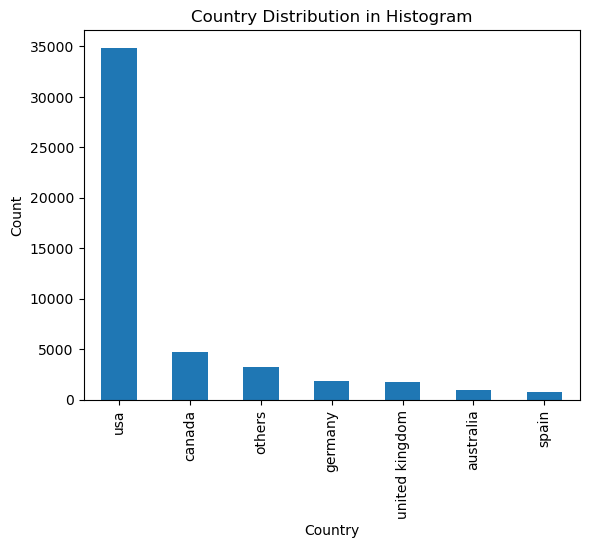

In [190]:
# identify countries have less than 10 users and combine them into a category called others
countries_to_combine = cleaned_users['User-Country'].value_counts()[cleaned_users['User-Country'].value_counts()<500].index

cleaned_users.loc[cleaned_users['User-Country'].isin(countries_to_combine), 'User-Country'] = "others"

cleaned_users['User-Country'].value_counts().plot(kind='bar')

plt.title('Country Distribution in Histogram')
plt.xlabel('Country')
plt.ylabel('Count')
plt.show()

In [199]:
cleaned_users['User-Country'].value_counts()

User-Country
usa               34862
canada             4666
others             3182
germany            1887
united kingdom     1786
australia           982
spain               793
Name: count, dtype: int64

In [192]:
# decrease different state in each country by only leaving the top 5 number of users state
top5_state = cleaned_users.groupby('User-Country')['User-State'].value_counts().groupby(level=0).nlargest(5).reset_index(level=0, drop=True)
top_state_list = top5_state.index.get_level_values(1).tolist()

top_state_dic = {}
for country in top5_state.index.get_level_values(0).unique():
    top_state_dic[country] = top5_state.loc[country].index.tolist()[:5]

print(top_state_dic)

{'australia': ['new south wales', 'victoria', 'queensland', 'south australia', 'western australia'], 'canada': ['ontario', 'british columbia', 'alberta', 'quebec', 'nova scotia'], 'germany': ['nordrhein-westfalen', 'bayern', 'baden-wuerttemberg', 'hessen', 'niedersachsen'], 'others': ['n/a', 'lombardia', 'ile de france', 'lazio', 'lisboa'], 'spain': ['madrid', 'barcelona', 'catalunya', 'n/a', 'valencia'], 'united kingdom': ['england', 'scotland', 'n/a', 'wales', 'london'], 'usa': ['california', 'texas', 'new york', 'florida', 'washington']}


In [193]:
# the rest of the state will be classified as others
for index, row in cleaned_users.iterrows():
    if row['User-State'] not in top_state_dic.get(row['User-Country'], []):
        cleaned_users.at[index, 'User-State'] = 'others'

print(cleaned_users.head())

   User-ID    User-City User-State User-Country  User-Age
0        8      timmins    ontario       canada      <NA>
1        9   germantown     others          usa      <NA>
2       16  albuquerque     others          usa      <NA>
3       17   chesapeake     others          usa      <NA>
4       19       weston    florida          usa        14


In [194]:
cleaned_users['User-State'].value_counts()

User-State
others                 26993
california              5193
texas                   2020
ontario                 1813
new york                1794
florida                 1668
washington              1612
british columbia        1237
england                 1089
n/a                      709
alberta                  639
nordrhein-westfalen      437
new south wales          304
victoria                 285
bayern                   277
quebec                   220
nova scotia              216
baden-wuerttemberg       214
hessen                   161
scotland                 136
niedersachsen            135
queensland               122
madrid                   113
lombardia                103
barcelona                102
south australia           90
catalunya                 90
western australia         81
ile de france             71
lazio                     59
wales                     59
lisboa                    54
london                    32
valencia                  30
Nam

In [197]:
# decrease different city in each country by only leaving the top 5 number of users city
top5_city = cleaned_users.groupby('User-Country')['User-City'].value_counts().groupby(level=0).nlargest(5).reset_index(level=0, drop=True)
top_city_list = top5_city.index.get_level_values(1).tolist()

top_city_dic = {}
for country in top5_city.index.get_level_values(0).unique():
    top_city_dic[country] = top5_city.loc[country].index.tolist()[:5]

print(top_city_dic)

{'australia': ['others', 'sydney', 'melbourne', 'adelaide', 'brisbane'], 'canada': ['others', 'toronto', 'vancouver', 'ottawa', 'calgary'], 'germany': ['others', 'berlin', 'hamburg', 'münchen', 'munich'], 'others': ['others', 'paris', 'singapore', 'christchurch', 'lisboa'], 'spain': ['others', 'barcelona', 'madrid', 'zaragoza', 'valencia'], 'united kingdom': ['others', 'london', 'manchester', 'edinburgh', 'glasgow'], 'usa': ['others', 'portland', 'seattle', 'chicago', 'san diego']}


In [196]:
# the rest of the cities will be classified as others
for index, row in cleaned_users.iterrows():
    if row['User-City'] not in top_city_dic.get(row['User-Country'], []):
        cleaned_users.at[index, 'User-City'] = 'others'

print(cleaned_users.head())

   User-ID User-City User-State User-Country  User-Age
0        8    others    ontario       canada      <NA>
1        9    others     others          usa      <NA>
2       16    others     others          usa      <NA>
3       17    others     others          usa      <NA>
4       19    others    florida          usa        14


In [198]:
cleaned_users['User-City'].value_counts()

User-City
others           42512
toronto            471
portland           468
seattle            433
chicago            395
san diego          363
london             360
san francisco      338
vancouver          319
ottawa             279
calgary            270
victoria           184
sydney             169
barcelona          167
melbourne          149
berlin             123
hamburg            123
madrid             107
paris              107
singapore           74
christchurch        68
lisboa              67
münchen             62
adelaide            59
manchester          57
edinburgh           49
brisbane            48
roma                48
munich              47
perth               45
bonn                41
zaragoza            40
glasgow             37
valencia            31
sheffield           31
bilbao              17
Name: count, dtype: int64

In [ ]:
# filter ages that are invalid (eg, greater than 100) which will later be grouped with nan value
# change empty entries to -1 which will be further group to others category
cleaned_users.loc[cleaned_users['User-Age'] > 100, 'User-Age'] = -1
cleaned_users['User-Age'].fillna(-1, inplace=True)
cleaned_users['User-Age'].astype(float).astype('Int64')
cleaned_users

/var/folders/2y/d2x11n9s4sbc3j2svdb5qdb00000gn/T/ipykernel_98845/548177487.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  cleaned_users['User-Age'].fillna(-1, inplace=True)
/var/folders/2y/d2x11n9s4sbc3j2svdb5qdb00000gn/T/ipykernel_98845/548177487.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_users['User-Age'].fillna(-1, inp

,User-ID,User-City,User-State,User-Country,User-Age
0,8,others,ontario,canada,-1
1,9,others,others,usa,-1
2,16,others,others,usa,-1
3,17,others,others,usa,-1
4,19,others,florida,usa,14
...,...,...,...,...,...
48294,278846,toronto,ontario,canada,23
48295,278849,others,ontario,canada,23
48296,278851,others,texas,usa,33
48297,278852,brisbane,queensland,australia,32


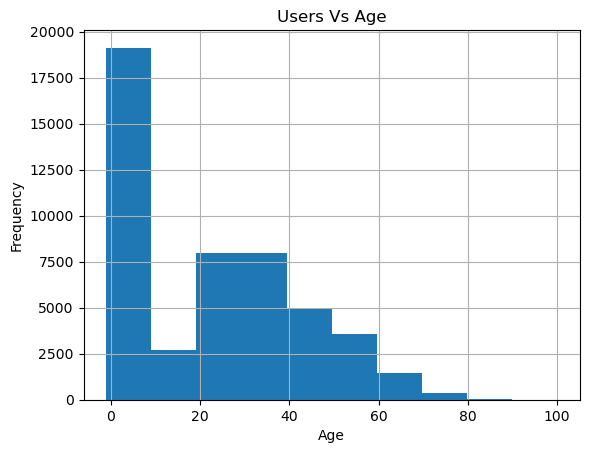

In [ ]:
# check age distribution
cleaned_users['User-Age'].hist(bins=10)

plt.title('Users Vs Age')
plt.xlabel('Age')
plt.ylabel('Frequency')

plt.show()

In [ ]:
# group NA age into a group and discretisation
# add bins to age intervals
bins = [-float('inf'),0,20,40,60,80,100]
labels = ["others","0~20","20~40","40~60","60~80","80~100"]

cleaned_users['User-Age-Bin'] = pd.cut(cleaned_users['User-Age'], bins=bins, labels=labels, include_lowest=True)

missing_users = cleaned_users.isna().sum()
print(missing_users)
cleaned_users

User-ID         0
User-City       0
User-State      0
User-Country    0
User-Age        0
User-Age-Bin    0
dtype: int64


/var/folders/2y/d2x11n9s4sbc3j2svdb5qdb00000gn/T/ipykernel_98845/3855932413.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_users['User-Age-Bin'] = pd.cut(cleaned_users['User-Age'], bins=bins, labels=labels, include_lowest=True)


,User-ID,User-City,User-State,User-Country,User-Age,User-Age-Bin
0,8,others,ontario,canada,-1,others
1,9,others,others,usa,-1,others
2,16,others,others,usa,-1,others
3,17,others,others,usa,-1,others
4,19,others,florida,usa,14,0~20
...,...,...,...,...,...,...
48294,278846,toronto,ontario,canada,23,20~40
48295,278849,others,ontario,canada,23,20~40
48296,278851,others,texas,usa,33,20~40
48297,278852,brisbane,queensland,australia,32,20~40


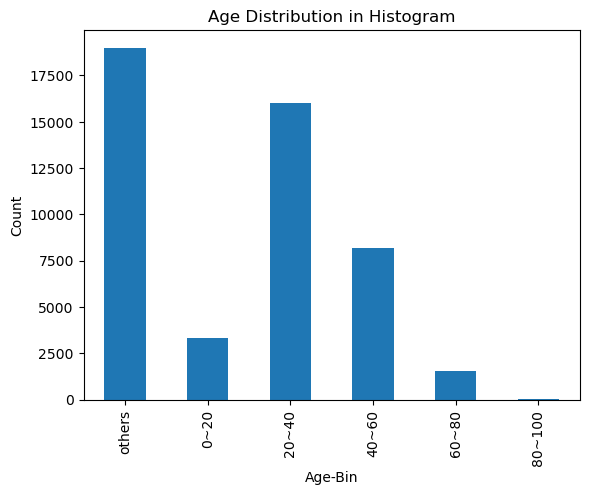

In [ ]:
# checking on age distribution
cleaned_users['User-Age-Bin'].value_counts().sort_index().plot(kind='bar')
plt.title('Age Distribution in Histogram')
plt.xlabel('Age-Bin')
plt.ylabel('Count')
plt.show()

In [ ]:
# check there are no missing values in city, state, country, and age
missing_value = cleaned_users.isna().sum()
print(missing_value)

# Encode users' city, state and country
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

cleaned_users['User-City_Encoded']= label_encoder.fit_transform(cleaned_users['User-City'])
cleaned_users['User-State_Encoded']= label_encoder.fit_transform(cleaned_users['User-State'])
cleaned_users['User-Country_Encoded']= label_encoder.fit_transform(cleaned_users['User-Country'])
cleaned_users['User-Age-Encoded']= label_encoder.fit_transform(cleaned_users['User-Age-Bin'])
cleaned_users

User-ID         0
User-City       0
User-State      0
User-Country    0
User-Age        0
User-Age-Bin    0
dtype: int64


/var/folders/2y/d2x11n9s4sbc3j2svdb5qdb00000gn/T/ipykernel_98845/1931410399.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_users['User-City_Encoded']= label_encoder.fit_transform(cleaned_users['User-City'])
/var/folders/2y/d2x11n9s4sbc3j2svdb5qdb00000gn/T/ipykernel_98845/1931410399.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_users['User-State_Encoded']= label_encoder.fit_transform(cleaned_users['User-State'])
/var/folders/2y/d2x11n9s4sbc3j2svdb5qdb00000gn/T/ipykernel_98845/1931

,User-ID,User-City,User-State,User-Country,User-Age,User-Age-Bin,User-City_Encoded,User-State_Encoded,User-Country_Encoded,User-Age-Encoded
0,8,others,ontario,canada,-1,others,19,22,1,5
1,9,others,others,usa,-1,others,19,23,6,5
2,16,others,others,usa,-1,others,19,23,6,5
3,17,others,others,usa,-1,others,19,23,6,5
4,19,others,florida,usa,14,0~20,19,8,6,0
...,...,...,...,...,...,...,...,...,...,...
48294,278846,toronto,ontario,canada,23,20~40,31,22,1,1
48295,278849,others,ontario,canada,23,20~40,19,22,1,1
48296,278851,others,texas,usa,33,20~40,19,28,6,1
48297,278852,brisbane,queensland,australia,32,20~40,5,25,0,1


In [ ]:
# save the valid users dataframe to a csv
cleaned_users.to_csv('cleaned_users.csv', index=False)
print(cleaned_users.dtypes)
cleaned_users

User-ID                    int64
User-City                 object
User-State                object
User-Country              object
User-Age                   Int64
User-Age-Bin            category
User-City_Encoded          int64
User-State_Encoded         int64
User-Country_Encoded       int64
User-Age-Encoded           int64
dtype: object


,User-ID,User-City,User-State,User-Country,User-Age,User-Age-Bin,User-City_Encoded,User-State_Encoded,User-Country_Encoded,User-Age-Encoded
0,8,others,ontario,canada,-1,others,19,22,1,5
1,9,others,others,usa,-1,others,19,23,6,5
2,16,others,others,usa,-1,others,19,23,6,5
3,17,others,others,usa,-1,others,19,23,6,5
4,19,others,florida,usa,14,0~20,19,8,6,0
...,...,...,...,...,...,...,...,...,...,...
48294,278846,toronto,ontario,canada,23,20~40,31,22,1,1
48295,278849,others,ontario,canada,23,20~40,19,22,1,1
48296,278851,others,texas,usa,33,20~40,19,28,6,1
48297,278852,brisbane,queensland,australia,32,20~40,5,25,0,1
